## Introduction: dataset of Spirtualist Newspaper


 * Images and METS/ALTO (positional XML)
 * Also available as plain text
 * 11,577,467 words
 * OCR: no clean-up
 * Also occasional illustrations within pages

# Setup

In [95]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

nlp = spacy.load("en_core_web_sm")

## 1) Describe

* Firstly, the general type of our data is textual
* it consists of 416 txt files, the lenth of each txt file is around 150000 
* one example is as following:

In [200]:
nlp = spacy.load("en_core_web_sm")
text = open("135908626.txt").read()
text

'A f^ECOF^D Of THE PROQREgf Of THE gCIEfICE /ND ETHICg OF gPIF^ITU/iUgM.\nNo. 10.—Vol. I. LONDON : WEDNESDAY, JUNE 15, 1870. mon^PriS, Thr^n^r617\nDR. NEWTON’S HEALING MEDIUMSHIP.\nDr. J. R. Newton, the healing medium, was horn in\nNewport, Rhode Island, United States, September 8th,\n1810, consequently he is now about sixty years of age,\nand it was eleven years and a half ago when he first\nbegan to devote the whole of his time to the healing of\nthe sick. In his lifetime he has passed through many\nchanges and sorrows, and has both made and lost\nseveral fortunes. He has often been in great danger\nof losing his life. When he was eight years old, a\nplaymate gave him a push one day as he was whittling\nwith a knife; he fell, and the blade of the knife went\ninto his breast right up to the handle, but he recovered\nfrom the effects of this accident. At the age of ten he\nfell from a tree, and was so much injured that his lower\nlimbs were paralysed, and he could only draw himself\nal

In [201]:
print('the lenth of this txt file is', len(text))

the lenth of this txt file is 161767


next, one csv file about the inventory of this data is analysised to summary statistic about the data:

* There are some misspelling needs in the inventory data to be corrected:

In [47]:
import os
def file_name(file_dir):   
    L=[]   
    for dirpath, dirnames, filenames in os.walk(file_dir):  
        for file in filenames :  
            if os.path.splitext(file)[1] == '.txt':  
                L.append(os.path.join(dirpath, file)[-13:])  
    return L 

files = file_name('Users/apple/Downloads/001S-text-spiritualistNewspaper')

In [48]:
catalog = pd.read_csv('spiritualistNewspaper-inventory.csv', header=None)
catalog.columns = ['filename', 'about']
time = []
month = []
year = []
for i in catalog['about']:
    t = i[i.find(',')+2:-7]
    time.append(t)
    m = i[i.find(',')+2:-17]
    month.append(m)
    y = i[-12:-7]
    year.append(y)
catalog['time'] = time
catalog['month'] = month
catalog['year'] = year

In [299]:
catalog = catalog.replace('Januar', 'January')
catalog = catalog.replace('Marc', 'March')
catalog = catalog.replace('Ma', 'March')
catalog = catalog.replace('Jun', 'June')
catalog = catalog.replace('Jul', 'July')
catalog = catalog.replace('Apr', 'April')
catalog = catalog.replace('Novemb', 'November')
catalog = catalog.replace('Septembe', 'September')
catalog = catalog.replace('Octobe', 'October')
catalog = catalog.replace('Februar', 'February')
catalog = catalog.replace('Apri', 'April')
catalog = catalog.replace('Augus', 'August')
catalog = catalog.replace('Novembe', 'November')
catalog = catalog.replace('Decembe', 'December')
catalog = catalog.replace('No.493, March 1882', 'March')
catalog = catalog.replace('No.493, May 1882', 'May')
print('the month distribution of the data is as follows:', catalog['month'].value_counts())

catalog = catalog.replace('77.a.', '1882') 

the month distribution of the data is as follows: March        47
January      37
December     37
July         36
June         35
April        35
November     35
February     33
October      32
August       32
September    30
May          27
Name: month, dtype: int64


In [257]:
print('the year distribution of the data is as follows:',
      catalog['year'].value_counts())

the year distribution of the data is as follows:  1875    53
 1877    52
 1876    52
 1879    52
 1874    52
 1878    52
 1880    31
 1873    28
 1872    14
 1870    12
 1871    12
 1869     4
1882      2
Name: year, dtype: int64


In [53]:
#put the content into list
import codecs
contents = []
for i in catalog['txt']:
    file = codecs.open(i, 'r')
    content = file.read()
    file.close()
    content = content.lower()
    contents.append(content)

In [54]:
catalog['content'] = contents

In [55]:
catalog.head()
catalog = catalog.drop(['about'], axis=1)
catalog.head()

,txt,time,month,year,content
0,135908617.txt,November 19th 1869,November,1869,■ «c>-\n• op ' °f:' ;t^e' 3c! e;ngev d • hi 0^...
1,135908618.txt,December 3rd 1869,December,1869,a f(ecof(d of the proqreff of the fciefce >nd ...
2,135908619.txt,December 17th 1869,December,1869,a f(ecof(d of the proqrefj3 of the fcleflce /n...
3,135908620.txt,December 31st 1869,December,1869,a f(ecof(d of the proqreff of the 3gie]mce /.n...
4,135908621.txt,January 14th 1870,January,1870,"no. 5.—vol. i. london : friday, january 14, 18..."


In [197]:
catalog['word_count'] = catalog['content'].apply(lambda x: len(str(x).split()))

Finally, the summarize of the statistic about the data is as follows:

In [193]:
catalog

,txt,time,month,year,content,word_count
0,135908617.txt,November 19th 1869,November,1869,■ «c>-\n• op ' °f:' ;t^e' 3c! e;ngev d • hi 0^...,27831
1,135908618.txt,December 3rd 1869,December,1869,a f(ecof(d of the proqreff of the fciefce >nd ...,28961
2,135908619.txt,December 17th 1869,December,1869,a f(ecof(d of the proqrefj3 of the fcleflce /n...,29594
3,135908620.txt,December 31st 1869,December,1869,a f(ecof(d of the proqreff of the 3gie]mce /.n...,29184
4,135908621.txt,January 14th 1870,January,1870,"no. 5.—vol. i. london : friday, january 14, 18...",28605
...,...,...,...,...,...,...
411,136346235.txt,July 16th 1880,July,1880,registered as a newspaper.\nno. 4l2.—(yol. xyi...,16819
412,136346236.txt,July 23rd 1880,July,1880,registered as a newspaper.\njp istel rnmtecf^b...,17001
413,136346237.txt,July 30th 1880,July,1880,registered as a newse^fer.\nfflfe sffijpm toft...,16974
414,136346239.txt,"No.493, March 1882 - K.77.a.",March,1882,"“ psyche,” formerly m the spiritualist” price ...",16385


## 2) Exploration 

* ## Main question

* How keyword and topic present and change in the first and last issue of the newspaper?

* ## Methods:

* Select the first one and the last one in txt files as two samples to analyze and make a comparison.
* the contnet and information of these two txt files is as the follows
* Topic exploration is based on the Latent Dirichlet Allocation (LDA) algorithm.
* Two sample are seclected in order to compare the first and last issues of the newspaper,and through comparison to find their differences and changes in newspaper issues.

In [270]:
#sample_1
catalog.head(1)

,txt,time,month,year,content,word_count
0,135908617.txt,November 19th 1869,November,1869,■ «c>-\n• op ' °f:' ;t^e' 3c! e;ngev d • hi 0^...,27831


In [267]:
#sample_2
catalog.tail(1)

,txt,time,month,year,content,word_count
415,136346240.txt,"No.493, May 1882 - K.77.a.",May,1882,a journal of religious philosophy and al-l- br...,19118


In [279]:
print('the lenth of sample_1 is',len(contents[0]))

the lenth of sample_1 is 162159


In [281]:
print('the lenth of sample_2 is',len(contents[415]))

the lenth of sample_2 is 112207


* ## Pre-processing 

In [82]:
# Normalization
import re
cleaned_words=re.sub(r"[^a-zA-z0-9]"," ",contents[0])
print(cleaned_words) 

   c     op    f    t^e  3c  e ngev d   hi 0^  pf  ^1^ t   xurnac i london  friday  ^oydmber i9j  186 9   mmrmi0^0  0  jq^ we^^ s ea^te       i          ri      in   1     ^^ts ^ piet  cine       j             uv^s  rt       jsfi r 1   j   r i       5n j  oi^ie  mtjst   pfcrfeet t  aigtheuv if  ate l  iasfe\nees of   spirit ra^prijirr   m^ticuvil hefore   tin   t tc innina  of the i wo^orn  matfifestatforlgf^took  place liu tut  family of jphn  j y\   slpyj   thcvifainent  is ligipiiaf fpfprmor  the facts   iyoreiyfesvtfcit   fiq^ hv onl tho  spot  and dho various dociiinfsiv idmi h    uman^    i t eit ciomt c i ot tlm  a t ^ivv  fu hcmc h tlir nn     rjui o  t the dog^^t jjts  ruse iulutul id oa all hands to be indisputably genuine   ahd  h ro authenticated by john wesley him  thefyfjiole  rite letters ct  the members of the of the    hjhgs of l jt hjaffi    wif^bo  gfhdvally reprinted in this  journal  in h ^l jei ttn  ji drose spiritualists  wesleyans  and i   cadets   ^ho  aae   nh

In [216]:
import re
cleaned_words2=re.sub(r"[^a-zA-z0-9]"," ",contents[415])
print(cleaned_words2) 

a journal of religious philosophy and al l  brangftes of psycmicat  science  no  498   vol  21  no  3   may  1882  ssce  pi ice 7s  6d  crown 8vo  clpth  red edges  a philosophy of immortality  by   the non  roden noel author of    a little child s monument   etc       ^ ^ 1 tsyche office  38  museum street  london  w c  crown svo  clpth  gilt  handsomely printed in red and black inks   price os  6d   post free  now ready   a glance at the paiston play  by captain e  e  bueton  the frontispiece represents the crucifixion scene of the passion play at oberammorgau      this woeh contains seveeal pages on the eeligious aspects of spiettualism  ^     psyche office  38  museum street  london  w c    ^ y   demy byo  cloth  red edges  price 12s  6d  post free  a illustrated py various full page and double page engravings  tran 8 0 e n4 e n t a l physios  an account of experimental investigations from the scientific treatises of johann gael feiedeich zollnee  professor of physical astronomy at

In [83]:
text= cleaned_words

In [217]:
text2= cleaned_words2

In [84]:
#tokenization 
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [85]:
# lemma 
import nltk
nltk.download('wordnet')

from nltk.corpus import wordnet as wn
def get_lemma(word):
    #dogs->dog
    #aardwolves->aardwolf'
    #sichuan->sichuan
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [86]:
# Prepare Stopwords
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

#Printing the total number of stop words:
print('Number of stop words: %d' % len(spacy_stopwords))

#Printing first ten stop words:
print('First ten stop words: %s' % list(spacy_stopwords)[:10])

Number of stop words: 329
First ten stop words: ['formerly', '’s', 'else', "n't", 'now', 'how', 'moreover', 'most', 'not', 'only']


In [87]:
def prepare_text_for_lda(text):
    #分词处理
    tokens = tokenize(text)
    tokens = [token for token in tokens if not len(token)<2]
    #取出非停顿词
    tokens = [token for token in tokens if token not in spacy_stopwords]
    #对词语进行还原
    tokens = [get_lemma(token) for token in tokens]
    # all tokens that arent stop words or punctuations
    #tokens = [token for token in token if token.is_stop != True and token.is_punct != True]

    
    return tokens

In [88]:
prepare_text_for_lda(text)

['op',
 't^e',
 '3c',
 'ngev',
 'hi',
 '0^',
 'pf',
 '^1^',
 'xurnac',
 'london',
 'friday',
 '^oydmber',
 'i9j',
 '186',
 'mmrmi0',
 'jq^',
 'we^^',
 'ea^te',
 'ri',
 '^^ts',
 'piet',
 'cine',
 'uv^s',
 'rt',
 'jsfi',
 '5n',
 'oi^ie',
 'mtjst',
 'pfcrfeet',
 'aigtheuv',
 'ate',
 'iasfe\\nees',
 'spirit',
 'ra^prijirr',
 'm^ticuvil',
 'hefore',
 'tin',
 'tc',
 'innina',
 'wo^orn',
 'matfifestatforlgf^took',
 'place',
 'liu',
 'tut',
 'family',
 'jphn',
 'y\\',
 'slpyj',
 'thcvifainent',
 'ligipiiaf',
 'fpfprmor',
 'fact',
 'iyoreiyfesvtfcit',
 'fiq^',
 'hv',
 'onl',
 'tho',
 'spot',
 'dho',
 'dociiinfsiv',
 'idmi',
 'uman^',
 'eit',
 'ciomt',
 'ot',
 'tlm',
 '^ivv',
 'fu',
 'hcmc',
 'tlir',
 'nn',
 'rjui',
 'dog^^t',
 'jjts',
 'ruse',
 'iulutul',
 'oa',
 'hands',
 'indisputably',
 'genuine',
 'ahd',
 'ro',
 'authenticate',
 'john',
 'wesley',
 'thefyfjiole',
 'rite',
 'letters',
 'ct',
 'member',
 'hjhgs',
 'jt',
 'hjaffi',
 'wif^bo',
 'gfhdvally',
 'reprint',
 'journal',
 '^l',
 'jei'

In [218]:
prepare_text_for_lda(text2)

['journal',
 'religious',
 'philosophy',
 'al',
 'brangftes',
 'psycmicat',
 'science',
 '498',
 'vol',
 '21',
 '1882',
 'ssce',
 'pi',
 'ice',
 '7',
 '6d',
 'crown',
 '8vo',
 'clpth',
 'red',
 'edge',
 'philosophy',
 'immortality',
 'non',
 'roden',
 'noel',
 'author',
 'little',
 'child',
 'monument',
 'etc',
 'tsyche',
 'office',
 '38',
 'museum',
 'street',
 'london',
 'crown',
 'svo',
 'clpth',
 'gilt',
 'handsomely',
 'print',
 'red',
 'black',
 'ink',
 'price',
 'os',
 '6d',
 'post',
 'free',
 'ready',
 'glance',
 'paiston',
 'play',
 'captain',
 'bueton',
 'frontispiece',
 'represent',
 'crucifixion',
 'scene',
 'passion',
 'play',
 'oberammorgau',
 'woeh',
 'contain',
 'seveeal',
 'page',
 'eeligious',
 'aspect',
 'spiettualism',
 'psyche',
 'office',
 '38',
 'museum',
 'street',
 'london',
 'demy',
 'byo',
 'cloth',
 'red',
 'edge',
 'price',
 '12',
 '6d',
 'post',
 'free',
 'illustrate',
 'py',
 'page',
 'double',
 'page',
 'engraving',
 'tran',
 'n4',
 'physios',
 'account'

In [89]:
cleaned_tokens=prepare_text_for_lda(text)

In [220]:
cleaned_tokens2=prepare_text_for_lda(text2)

* ## Explore

## (1) Most commom Words in 1869 and 1882

In [90]:
freq = nltk.FreqDist(cleaned_tokens)
for key,val in freq.items():
    print(str(key) + ':' + str(val))

op:2
t^e:1
3c:1
ngev:1
hi:4
0^:1
pf:2
^1^:1
xurnac:1
london:32
friday:4
^oydmber:1
i9j:1
186:1
mmrmi0:1
jq^:1
we^^:1
ea^te:1
ri:1
^^ts:1
piet:1
cine:1
uv^s:1
rt:1
jsfi:1
5n:1
oi^ie:1
mtjst:1
pfcrfeet:1
aigtheuv:1
ate:1
iasfe\nees:1
spirit:75
ra^prijirr:1
m^ticuvil:1
hefore:1
tin:1
tc:1
innina:1
wo^orn:1
matfifestatforlgf^took:1
place:44
liu:1
tut:1
family:18
jphn:1
y\:1
slpyj:1
thcvifainent:1
ligipiiaf:1
fpfprmor:1
fact:51
iyoreiyfesvtfcit:1
fiq^:1
hv:1
onl:1
tho:1
spot:5
dho:1
dociiinfsiv:1
idmi:1
uman^:1
eit:1
ciomt:1
ot:2
tlm:1
^ivv:1
fu:1
hcmc:1
tlir:1
nn:1
rjui:1
dog^^t:1
jjts:1
ruse:1
iulutul:1
oa:1
hands:27
indisputably:1
genuine:7
ahd:1
ro:2
authenticate:4
john:21
wesley:12
thefyfjiole:1
rite:1
letters:15
ct:1
member:19
hjhgs:1
jt:1
hjaffi:1
wif^bo:1
gfhdvally:1
reprint:2
journal:22
^l:1
jei:1
ttn:1
ji:3
drose:1
spiritualist:59
wesleyan:1
cadet:1
^ho:1
aae:1
nhaerjuaiuied:1
witb:1
cht:1
uotnal:1
tvlivulilifihsii:1
orthl^ibciysr:1
itfc:1
warn:1
eomiug:1
fliieti:1
ti:2
reasorir:1

straight:2
rushing:1
heaven:5
stairs:1
entering:1
gaze:1
young:13
lying:1
violent:5
hysterics:1
overwhelm:1
terror:1
tripod:1
dancing:1
frantically:1
measure:2
consternation:1
create:1
entrance:4
amble:1
door:4
low:3
bow:1
execute:2
terpsichorean:1
extrava:1
gances:1
strive:1
calm:1
beginning:2
cover:4
bob:1
nonsense:2
explanation:3
hisabsence:1
trey:1
consist:7
father:3
bluff:1
incredulous:1
yorkshireman:2
obtain:24
sic:1
sea:3
nee:1
firmly:1
private:8
incapable:1
trickery:4
imposture:12
cer:1
tain:2
belong:2
ring:1
torment:1
wasp:1
smell:1
mere:1
biologised:1
merely:1
biology:2
explain:5
account:7
instance:12
production:6
elaborate:1
crayon:3
second:9
mark:5
enable:4
certainty:1
identify:1
possession:3
glad:4
modus:1
operandi:1
clean:3
box:2
rapid:1
scratching:2
fall:4
ready:4
inspection:1
borthwick:1
propound:1
theory:10
regard:3
substantiate:1
blank:1
thosev:1
shawl:1
tie:1
complete:3
chevalier:1
diabolical:2
candidly:1
acknow:1
ledged:1
stop:3
trinity:4
adelina:1
marks:1
narrow:1


institution:4
speculum:1
country:2
crush:1
weight:2
authority:1
isaac:1
newton:7
brougham:3
shot:1
infinite:1
philosopher:2
labour:2
overlook:1
fara:1
attain:3
notwithstanding:2
rich:2
thereof:1
differ:2
subtilty:1
mobility:1
caloric:1
ether:1
gravita:1
agent:1
remote:1
compatible:1
refine:1
immaterial:2
freely:2
pervade:2
gross:2
analogy:1
exclude:1
ences:1
maintain:1
teem:1
speculate:1
possibility:1
independent:2
spibitual:1
libeaey:1
lending:2
kindred:2
burns:9
bookseller:2
stationer:1
furtherance:2
september:1
presidency:1
welcome:1
peebles:1
consul:1
trebizonde:1
government:3
ba:4
nner:1
importation:1
undertaking:1
wellington:1
camberwell:2
scarce:1
progressive:5
jects:1
growth:1
render:3
advisable:1
extensive:2
unselfish:1
working:1
owner:1
facility:4
help:3
entirely:4
injurious:1
competition:1
avoid:2
strengthen:2
establishment:3
appaeitions:1
hazard:1
finding:2
announce:2
enormous:1
collateral:1
po:2
sessors:1
seal:1
confidence:1
ridicule:1
answees:1
coeeespondents:1
edinburgh:

In [221]:
freq2 = nltk.FreqDist(cleaned_tokens2)
for key,val in freq.items():
    print(str(key) + ':' + str(val))

op:2
t^e:1
3c:1
ngev:1
hi:4
0^:1
pf:2
^1^:1
xurnac:1
london:32
friday:4
^oydmber:1
i9j:1
186:1
mmrmi0:1
jq^:1
we^^:1
ea^te:1
ri:1
^^ts:1
piet:1
cine:1
uv^s:1
rt:1
jsfi:1
5n:1
oi^ie:1
mtjst:1
pfcrfeet:1
aigtheuv:1
ate:1
iasfe\nees:1
spirit:75
ra^prijirr:1
m^ticuvil:1
hefore:1
tin:1
tc:1
innina:1
wo^orn:1
matfifestatforlgf^took:1
place:44
liu:1
tut:1
family:18
jphn:1
y\:1
slpyj:1
thcvifainent:1
ligipiiaf:1
fpfprmor:1
fact:51
iyoreiyfesvtfcit:1
fiq^:1
hv:1
onl:1
tho:1
spot:5
dho:1
dociiinfsiv:1
idmi:1
uman^:1
eit:1
ciomt:1
ot:2
tlm:1
^ivv:1
fu:1
hcmc:1
tlir:1
nn:1
rjui:1
dog^^t:1
jjts:1
ruse:1
iulutul:1
oa:1
hands:27
indisputably:1
genuine:7
ahd:1
ro:2
authenticate:4
john:21
wesley:12
thefyfjiole:1
rite:1
letters:15
ct:1
member:19
hjhgs:1
jt:1
hjaffi:1
wif^bo:1
gfhdvally:1
reprint:2
journal:22
^l:1
jei:1
ttn:1
ji:3
drose:1
spiritualist:59
wesleyan:1
cadet:1
^ho:1
aae:1
nhaerjuaiuied:1
witb:1
cht:1
uotnal:1
tvlivulilifihsii:1
orthl^ibciysr:1
itfc:1
warn:1
eomiug:1
fliieti:1
ti:2
reasorir:1

emanation:6
subtle:1
thirteen:2
alive:3
seek:4
publicity:1
honours:2
delight:2
spend:3
found:16
curious:7
shell:14
mineral:3
sensitive:5
conclusion:2
surround:5
material:6
sight:3
conduct:4
absolutely:5
clair:2
voyant:1
patient:4
lady:10
take:23
english:7
foreign:2
wrap:2
piano:2
luminous:4
pink:1
lambent:1
flame:3
smoke:1
arise:2
reach:5
ceil:1
pewter:1
painful:1
distinctly:2
hearer:1
dupe:1
girl:5
test:14
fresh:2
lot:1
dozen:4
bringing:1
short:5
range:2
eyes:11
writing:13
write:29
pitch:1
admit:5
agree:1
exactly:4
case:18
lately:3
piece:4
separately:2
difference:1
aura:6
ill:3
trace:4
putrefy:1
spoke:2
magnet:3
reichenbach:3
filing:1
taranaki:1
sand:3
sift:1
particle:2
arrange:3
line:9
magnetic:1
distance:6
beneath:1
proceeding:2
right:8
wooden:4
solid:5
necessary:9
conditions:8
sensi:2
tives:1
proceeds:1
aware:2
combustion:1
elements:5
food:1
exercise:3
sent:6
health:5
property:1
certain:11
individual:7
large:16
extent:2
curing:1
sick:1
influ:1
ence:3
reality:5
proof:2
exist:7
sunli

picturesque:1
crystal:1
palace:2
kingston:1
tbames:1
mesmerism:6
clairvoyance:5
sheldon:1
chadwick:4
voyance:1
school:2
stoke:1
newington:1
montague:2
self:2
middle:1
platform:2
wtalks:1
choose:2
pocket:1
common:6
conjuring:1
ordinary:6
wording:1
preconcerted:1
sharp:1
blindfold:2
col:1
league:1
catch:3
amiss:1
purse:1
baby:1
shoes:1
tape:1
locket:1
crown:2
hat:2
10:3
perfect:1
chosen:4
guess:1
push:1
unexpected:2
exchange:1
200:1
chad:1
wick:1
willing:1
strongly:3
instead:1
collusion:1
single:5
activity:2
passion:1
rigidity:1
stone:2
concentrate:1
faculty:1
fold:1
leaf:1
imperiously:1
will:1
governing:1
wake:2
practically:1
theological:1
curative:1
demoniacal:2
preposterous:1
send:3
disease:7
royal:5
household:1
windsor:1
castle:1
addison:3
toe:1
seize:1
naked:1
style:2
insult:4
personal:4
tale:4
wholly:1
untrue:1
misconduct:1
assertion:2
half:3
comic:1
actor:1
pretending:1
fit:5
caricature:1
elder:2
opposition:1
respectable:4
maybe:2
column:8
testify:3
premises:3
epes:3
sargent:3
pla

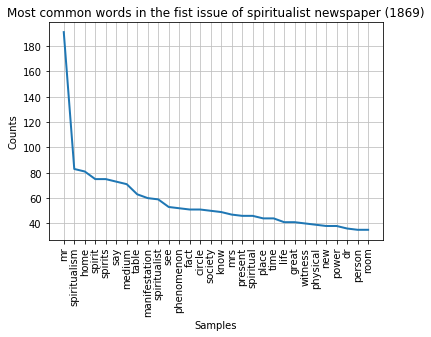

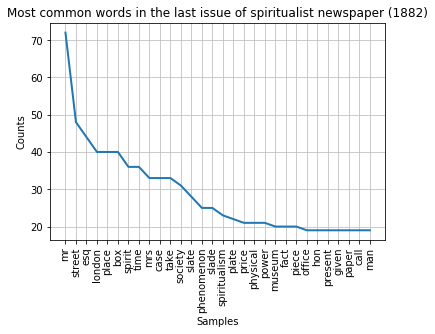

In [291]:
freq.plot(30, cumulative=False, title='Most common words in the fist issue of spiritualist newspaper (1869)') 
freq2.plot(30, cumulative=False,title='Most common words in the last issue of spiritualist newspaper (1882)')

## According to the plot, we can find:

* (1) In terms of gender：
* 'Mr' is the most frequently presented word both in the newspaper of 1869 and 1882.And both in 1869 and 1882, the frequency of 'mr' is higher than 'mrs'.

* (2) In terms of social class：
* In 1869,'Dr'is one of the most common words related to social class and raned 27th
* in 1882,'esq'is one of the most common words relaed to social class and ranked 3th

* (2) In terms of location：
* In 1869, there was no 'location' frequently presented in the newspaper
* in 1882,'london'is one of the most common words and ranked 4th

## (2) Topics in the newspaper of 1869 and 1882 

* a LDA model is built in order to know what topics is presented in the newspaper of 1869 and 1882 

## Topics and its keywords presented in sample_1 

In [92]:
dictionary = corpora.Dictionary([cleaned_tokens])

In [93]:
#Creating Bigram and Trigram Models
# Build the bigram and trigram models
bigram = gensim.models.Phrases(cleaned_tokens, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[cleaned_tokens], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[cleaned_tokens]])

['op', 't^e', '3c', 'ngev', 'hi', '0^', 'pf', '^1^', 'xurnac', 'london', 'friday', '^oydmber', 'i9j', '186', 'mmrmi0', 'jq^', 'we^^', 'ea^te', 'ri', '^^ts', 'piet', 'cine', 'uv^s', 'rt', 'jsfi', '5n', 'oi^ie', 'mtjst', 'pfcrfeet', 'aigtheuv', 'ate', 'iasfe\\nees', 'spirit', 'ra^prijirr', 'm^ticuvil', 'hefore', 'tin', 'tc', 'innina', 'wo^orn', 'matfifestatforlgf^took', 'place', 'liu', 'tut', 'family', 'jphn', 'y\\', 'slpyj', 'thcvifainent', 'ligipiiaf', 'fpfprmor', 'fact', 'iyoreiyfesvtfcit', 'fiq^', 'hv', 'onl', 'tho', 'spot', 'dho', 'dociiinfsiv', 'idmi', 'uman^', 'eit', 'ciomt', 'ot', 'tlm', '^ivv', 'fu', 'hcmc', 'tlir', 'nn', 'rjui', 'dog^^t', 'jjts', 'ruse', 'iulutul', 'oa', 'hands', 'indisputably', 'genuine', 'ahd', 'ro', 'authenticate', 'john', 'wesley', 'thefyfjiole', 'rite', 'letters', 'ct', 'member', 'hjhgs', 'jt', 'hjaffi', 'wif^bo', 'gfhdvally', 'reprint', 'journal', '^l', 'jei', 'ttn', 'ji', 'drose', 'spiritualist', 'wesleyan', 'cadet', '^ho', 'aae', 'nhaerjuaiuied', 'witb'

In [94]:
# Create Dictionary
id2word = corpora.Dictionary([cleaned_tokens])

# Create Corpus
texts = cleaned_tokens

# Term Document Frequency
corpus = [id2word.doc2bow(cleaned_tokens) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 4), (8, 2), (9, 1), (10, 10), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 7), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 7), (29, 13), (30, 1), (31, 9), (32, 1), (33, 1), (34, 1), (35, 3), (36, 1), (37, 1), (38, 2), (39, 3), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 

In [118]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

The keywords for each topic and the weightage(importance) of each keyword as shown.

In [119]:
# Print the Keyword in the 20 topics in the first issue of the newspaper(1869)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"mr" + 0.007*"spiritualism" + 0.006*"spirit" + 0.006*"say" + '
  '0.006*"spirits" + 0.005*"society" + 0.005*"table" + 0.005*"medium" + '
  '0.005*"spiritualist" + 0.005*"see"'),
 (1,
  '0.014*"mr" + 0.007*"spiritualism" + 0.006*"home" + 0.006*"say" + '
  '0.006*"medium" + 0.006*"spirit" + 0.006*"spirits" + 0.006*"mrs" + '
  '0.005*"table" + 0.005*"manifestation"'),
 (2,
  '0.017*"mr" + 0.008*"spiritualism" + 0.007*"spirits" + 0.006*"phenomenon" + '
  '0.006*"table" + 0.006*"home" + 0.006*"know" + 0.005*"manifestation" + '
  '0.005*"medium" + 0.005*"spirit"'),
 (3,
  '0.015*"mr" + 0.007*"home" + 0.006*"medium" + 0.006*"spiritualism" + '
  '0.006*"manifestation" + 0.005*"say" + 0.005*"table" + 0.005*"spirit" + '
  '0.005*"society" + 0.004*"see"'),
 (4,
  '0.013*"mr" + 0.008*"spiritualism" + 0.007*"home" + 0.007*"medium" + '
  '0.006*"spirit" + 0.006*"say" + 0.005*"spiritualist" + 0.005*"fact" + '
  '0.004*"place" + 0.004*"spirits"'),
 (5,
  '0.013*"mr" + 0.008*"spirits" + 0

In [120]:
lda_model.save('lda_model.model')

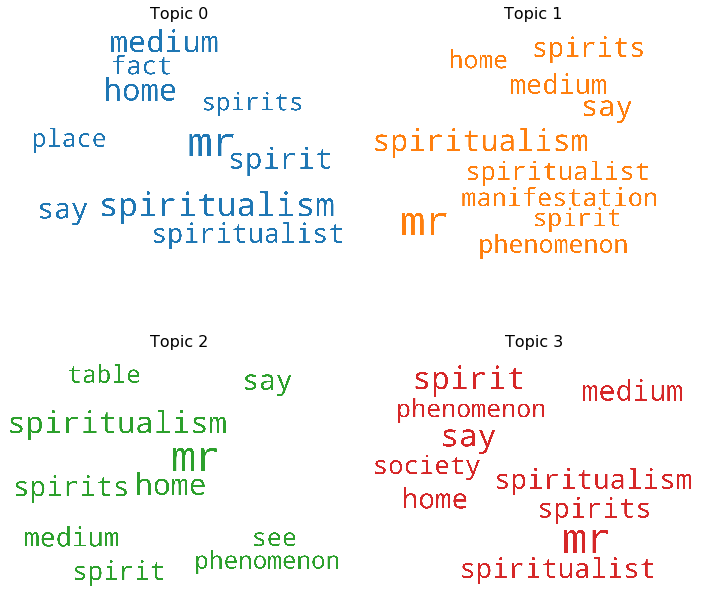

In [121]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=spacy_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Topic 0 is a represented as 0.017*"mr" + 0.007*"spiritualism" + 0.006*"spirit" + 0.006*"say" + '
  '0.006*"spirits" + 0.005*"society" + 0.005*"table" + 0.005*"medium" + '
  '0.005*"spiritualist" + 0.005*"see".
  
It means the top 10 keywords that contribute to this topic are: ‘mr’, ‘spiritualism’, ‘society’.. and so on and the size of word in the plot related to the weights of keyword.

The weights reflect how important a keyword is to that topic.

## Explanation

(1) In 1869, the topics of the newspaper mainly foucs on the theme of spritualism, keyword like 'medium' plays a important role in these topics.

According to Lavoie(2012), spiritualism was one of the biggest religious movement in the Victorian era. It means the belief that humans can communicate with the dead. It revolved around communication with the dead through different mediums. As far as Victorian spiritualism is concerned it encompassed plenty of odd practices which fell out of popularity like seances and spirit photography.


## Topics and its keywords presented in sample_2 

In [227]:
dictionary2 = corpora.Dictionary([cleaned_tokens2])

In [228]:
#Creating Bigram and Trigram Models
# Build the bigram and trigram models
bigram = gensim.models.Phrases(cleaned_tokens, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[cleaned_tokens], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[cleaned_tokens]])

['op', 't^e', '3c', 'ngev', 'hi', '0^', 'pf', '^1^', 'xurnac', 'london', 'friday', '^oydmber', 'i9j', '186', 'mmrmi0', 'jq^', 'we^^', 'ea^te', 'ri', '^^ts', 'piet', 'cine', 'uv^s', 'rt', 'jsfi', '5n', 'oi^ie', 'mtjst', 'pfcrfeet', 'aigtheuv', 'ate', 'iasfe\\nees', 'spirit', 'ra^prijirr', 'm^ticuvil', 'hefore', 'tin', 'tc', 'innina', 'wo^orn', 'matfifestatforlgf^took', 'place', 'liu', 'tut', 'family', 'jphn', 'y\\', 'slpyj', 'thcvifainent', 'ligipiiaf', 'fpfprmor', 'fact', 'iyoreiyfesvtfcit', 'fiq^', 'hv', 'onl', 'tho', 'spot', 'dho', 'dociiinfsiv', 'idmi', 'uman^', 'eit', 'ciomt', 'ot', 'tlm', '^ivv', 'fu', 'hcmc', 'tlir', 'nn', 'rjui', 'dog^^t', 'jjts', 'ruse', 'iulutul', 'oa', 'hands', 'indisputably', 'genuine', 'ahd', 'ro', 'authenticate', 'john', 'wesley', 'thefyfjiole', 'rite', 'letters', 'ct', 'member', 'hjhgs', 'jt', 'hjaffi', 'wif^bo', 'gfhdvally', 'reprint', 'journal', '^l', 'jei', 'ttn', 'ji', 'drose', 'spiritualist', 'wesleyan', 'cadet', '^ho', 'aae', 'nhaerjuaiuied', 'witb'

In [234]:
# Create Dictionary
id2word_2 = corpora.Dictionary([cleaned_tokens2])

# Create Corpus
texts_2 = cleaned_tokens2

# Term Document Frequency
corpus_2 = [id2word.doc2bow(cleaned_tokens2) for text in texts_2]

# View
print(corpus_2[:1])

[[(0, 1), (1, 4), (2, 5), (3, 1), (4, 2), (5, 6), (6, 3), (7, 1), (8, 1), (9, 1), (10, 2), (11, 2), (12, 1), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 4), (24, 3), (25, 1), (26, 3), (27, 10), (28, 1), (29, 1), (30, 1), (31, 1), (32, 3), (33, 1), (34, 3), (35, 1), (36, 2), (37, 2), (38, 3), (39, 2), (40, 1), (41, 1), (42, 1), (43, 4), (44, 1), (45, 1), (46, 1), (47, 1), (48, 6), (49, 4), (50, 1), (51, 7), (52, 1), (53, 1), (54, 2), (55, 3), (56, 1), (57, 4), (58, 3), (59, 1), (60, 1), (61, 16), (62, 1), (63, 5), (64, 1), (65, 1), (66, 1), (67, 1), (68, 3), (69, 1), (70, 1), (71, 3), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 2), (79, 10), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 3), (87, 1), (88, 1), (89, 2), (90, 1), (91, 1), (92, 1), (93, 16), (94, 1), (95, 1), (96, 1), (97, 1), (98, 4), (99, 3), (100, 1), (101, 2), (102, 1), (103, 2), (104, 1), (105, 7), (106, 1), (107, 1), (108, 1), (109, 1), (110

In [235]:
# Build LDA model
lda_model_2 = gensim.models.ldamodel.LdaModel(corpus=corpus_2,
                                           id2word=id2word_2,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [236]:
# Print the Keyword in the 10 topics in 1882
pprint(lda_model_2.print_topics())
doc_lda_2 = lda_model_2[corpus_2]

[(0,
  '0.007*"mr" + 0.005*"esq" + 0.005*"box" + 0.005*"spirit" + 0.004*"street" + '
  '0.004*"mrs" + 0.004*"place" + 0.004*"take" + 0.004*"london" + '
  '0.004*"society"'),
 (1,
  '0.008*"mr" + 0.005*"time" + 0.005*"spirit" + 0.005*"street" + 0.005*"place" '
  '+ 0.005*"take" + 0.004*"esq" + 0.004*"london" + 0.004*"box" + '
  '0.004*"society"'),
 (2,
  '0.006*"street" + 0.006*"mr" + 0.005*"esq" + 0.004*"place" + 0.004*"london" '
  '+ 0.004*"case" + 0.004*"mrs" + 0.004*"time" + 0.004*"take" + 0.003*"slate"'),
 (3,
  '0.009*"mr" + 0.006*"street" + 0.005*"esq" + 0.005*"london" + 0.004*"box" + '
  '0.004*"time" + 0.004*"society" + 0.004*"case" + 0.004*"place" + '
  '0.003*"spirit"'),
 (4,
  '0.007*"mr" + 0.006*"esq" + 0.005*"street" + 0.005*"london" + 0.004*"box" + '
  '0.004*"spirit" + 0.004*"take" + 0.004*"time" + 0.004*"case" + '
  '0.003*"slate"'),
 (5,
  '0.007*"mr" + 0.006*"street" + 0.005*"esq" + 0.004*"london" + 0.004*"time" + '
  '0.004*"case" + 0.004*"place" + 0.004*"society" + 

In [238]:
lda_model.save('lda_model.model_2')

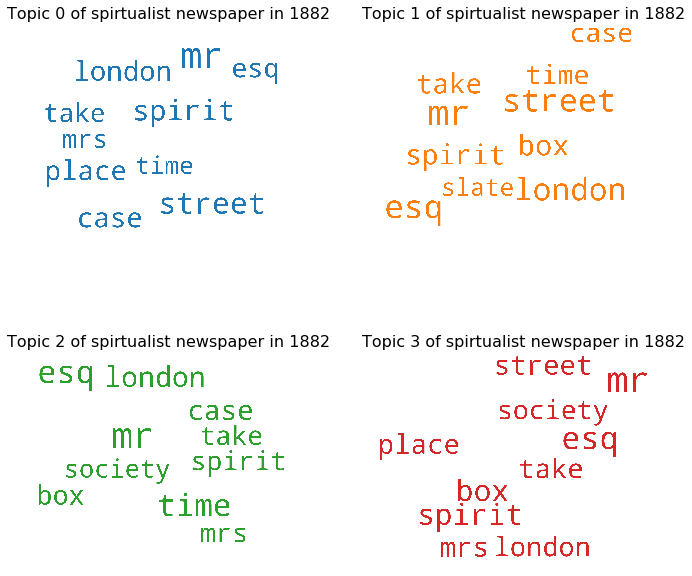

In [252]:
# 1. Wordcloud of Top N words in each topic in 1882
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=spacy_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_2.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i)+' of spirtualist newspaper in 1882', fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Explanation

Overall, in 1882, 'london' and 'esq' beacome the most important keyword contributed to many topics. it can be inferred that reports and activities during this period still highly related with the middle class.
According to Notestein(1954),Esquire is a title of a gentleman of the rank immediately below a knight. It was originally a military office, an esquire being (as the name escuyer, from escu, a shield, implies) a knight's attendant and shield bearer.Owen(2004) also states, the spiritualism of 1870s was most securely established amongst the ranks of respectable working-and middle-class.

In terms of gender, mrs also contributd to 3 topics in the last newspaper of 1882. It reflects that woman are also highly related to the movement and become more frequently mentioned in the topics of the newspaper."spiritualism was not untouched by'the woman question', on the contrary, progressive spiritualists were very much concerned with the issues involved."(Owen,2004)


## 3) Reflect and Hypothesise

## A comparison  in the first and last issue of the newspaper

## Hypotheses

H1：Compared to men, women play an increasingly important role in the spiritual movement compared to men.


* According to the graph of common words and the topic model,in 1869, the title of male dominated the common words and topic model,title of female like'mrs' was mentioned 50 times，but not as frequent as the male,which was mentioned 190 times. The title of Men are mentioned as four times as many as women.
* However in 1882, the gap in the frequency of title mentioned between male and female narrows,The title of Men are mentioned as two times as many as women.

H2: The influence of spiritualism gradually spread from individuals to society from 1869 to 1882


* Based on the comparison of the topic model in 1869 and 1882, the topic model of 1869 showed that 'home' is a keyword to the topic while in 1882 the word of 'society' contribute a lot instead of the 'home'

H3: The middle social class are highly involved in this movement


* in 1869, Dr is the keyword of social class appears in the most comon word. And in 1882, eqs is a keyword frequently presented in most of the topic model. 

## Test

First of all, I think asking data holder can be considered as a simple way, but a better approach is that the assumptions drawn from the data can be tested and verified by relevant research and literature.


In addition, due to the limitations of computer system configuration, my Python's execution efficiency in nlp is very low (it usually takes 1-2 hours or more to create a model), so I have to try to reduce the number of samples for analysis, if there are more opportunities for conducting further research, it would be better to analyze all the files, which may require more advanced algorithms to solve the problem of operational efficiency and large data volume.

## Reference

Notestein, W. (1954). English people on the eve of colonization, 1603-1630.pp45-60

Owen, A. (2004). The darkened room: Women, power, and spiritualism in late Victorian England. University of Chicago Press.

Lavoie, J. D. (2012). The theosophical society: the history of a Spiritualist Movement. Universal-Publishers.